# 2b. Replication Method

In [23]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import econtools.metrics as mt
import numpy as np
from econtools import read, outreg, table_statrow, write_notes
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('seaborn-v0_8-deep')

In [72]:
# Test and training sets
original_df = pd.read_csv(r'https://raw.githubusercontent.com/Faxulous/notFeelingTheBuzz/main/DataFiles/ramirez_matches_cleaned.csv', index_col=0)
fitset = original_df[~(original_df['date'] > '2019-01-00')].copy()
testset = original_df[(original_df['date'] > '2019-01-00')].copy()

testset.reset_index(inplace=True)
print('Fit set rows: '+str(len(fitset)))
print('Test set rows: '+str(len(testset)))

Fit set rows: 15854
Test set rows: 5190


In [113]:
testset[testset.isna().any(axis=1)]

,index,match_id,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,model_est_prob,kelly_betsize,PnL,Cum_PnL
16,1975,1975,Kirsten Flipkens,2019-01-01,2019.0,-0.011376,0.155601,NaN,0.546448,0.523560,1,0.519470,0.000000,0.000000,20.007117
22,1975,1975,Sachia Vickery,2019-01-01,2019.0,0.011376,-0.155601,NaN,0.505051,0.469484,0,0.475462,0.011270,-0.011270,-1.578095
588,3959,3959,Lesia Tsurenko,2019-02-12,2019.0,-0.031028,0.829121,NaN,0.793651,0.709220,1,0.777899,0.236191,0.096838,40.877837
597,3959,3959,Lara Arruabarrena,2019-02-12,2019.0,0.031028,-0.829121,NaN,0.220264,0.139470,0,0.178505,0.045361,-0.045361,15.644157
680,4019,4019,Evgeniya Rodina,2019-02-19,2019.0,-0.007755,-1.284016,NaN,0.704225,0.657895,1,0.668393,0.030688,0.015958,62.384397
690,4019,4019,Viktoriya Tomova,2019-02-19,2019.0,0.007755,1.284016,NaN,0.295858,0.163934,0,0.273831,0.131445,-0.131445,62.834779
783,4066,4066,Tatjana Maria,2019-02-26,2019.0,-0.008469,-2.014201,NaN,0.621118,0.621118,1,0.576556,0.000000,0.000000,78.575538
784,4066,4066,Martina Trevisan,2019-02-26,2019.0,0.008469,2.014201,NaN,0.429185,0.429185,0,0.417150,0.000000,-0.000000,78.575538
884,5754,5754,Kirsten Flipkens,2019-03-08,2019.0,-0.004159,0.465737,NaN,0.297619,0.277778,1,0.267586,0.000000,0.000000,101.298416
888,5754,5754,Eugenie Bouchard,2019-03-08,2019.0,0.004159,-0.465737,NaN,0.751880,0.735294,0,0.725295,0.000000,-0.000000,101.298416


In [117]:
# All functions used for results

# Select regression by setting rankdist and wikibuzz True or False.
# For models PM, PM w/o RD (aka. WB), RD, MO.
def fit_regression(rankdist: bool = True, wikibuzz: bool = True):
    if wikibuzz and rankdist:
        results = mt.reg(fitset,'outcome',                      
        ['inverse_avg', 'rankdist', 'wikibuzz'],
        #fe_name= "year",
        cluster='match_id',
        addcons=True)
        params = [results.beta[-1], results.beta[0], results.beta[1], results.beta[2]]
        #params= [constant        , inverse_avg    , rankdist       , wikibuzz       ]
    elif wikibuzz and not rankdist:
        results = mt.reg(fitset,'outcome',
        ['inverse_avg', 'wikibuzz'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0], results.beta[1]]
        #params= [constant        , inverse_avg    , wikibuzz       ]
    elif rankdist and not wikibuzz:
        results = mt.reg(fitset,'outcome',
        ['inverse_avg', 'rankdist'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0], results.beta[1]]
        #params= [constant        , inverse_avg    , rankdist       ]
    elif not rankdist and not wikibuzz:
        results = mt.reg(fitset,'outcome',                      
        ['inverse_avg'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0]]
        #params= [constant        , inverse_avg    ]
    print(results)
    return params

# Returns model's estimated probability.
def estimate_probability(params: pd.Series,
                         inverse_odds: float,
                         rankdist: float = None,
                         wikibuzz: float = None) -> float:
    if (rankdist is not None) & (wikibuzz is not None):
        y_hat = params[0] + params[-3]*inverse_odds + params[-2]*rankdist + params[-1]*wikibuzz
    if (rankdist is not None) & (wikibuzz is None):
        y_hat = params[0] + params[-2] * inverse_odds + params[-1] * rankdist
    if (wikibuzz is not None) & (rankdist is None):
        y_hat = params[0] + params[-2]*inverse_odds + params[-1]*wikibuzz
    if (rankdist is None) and (wikibuzz is None):
        y_hat = params[0] + params[1]*inverse_odds
    print(params[0])
    return y_hat

def kelly_criterion(odds_implied_prob, y_hat):
    odds = 1/odds_implied_prob
    k = max(y_hat - ((1 - y_hat)/(odds - 1)), 0)
    return k

# Calculates Profit/Loss.
def profit_loss(kelly, odds_implied_prob, outcome):
    odds = 1 / odds_implied_prob
    if outcome == 1:
        PnL = kelly*odds - kelly
    if outcome == 0:
        PnL = -kelly
    return PnL

# Estimates probability according to model selection, creates new columns, and prints results
def show_results(testset, params, odds, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"

    # Estimate Probability.
    if rankdist and wikibuzz:
        testset['model_est_prob'] = [estimate_probability(params, row[0], row[1], row[2]) for row in zip(testset['inverse_avg'],
                                                                                                         testset['rankdist'],
                                                                                                         testset['wikibuzz'])]
    elif wikibuzz and not rankdist:
        testset['model_est_prob'] = [estimate_probability(params, inverse_odds=row[0], wikibuzz=row[1]) for row in zip(testset['inverse_avg'],
                                                                                                                       testset['wikibuzz'])]
    elif rankdist and not wikibuzz:
        testset['model_est_prob'] = [estimate_probability(params, inverse_odds=row[0], rankdist=row[1]) for row in zip(testset['inverse_avg'],
                                                                                                                       testset['rankdist'])]
    elif not rankdist and not wikibuzz:
        testset['model_est_prob'] = [simple_probability(params, inverse_odds=x) for x in testset['inverse_avg']]          
    # Determine kelly bet size.
    testset['kelly_betsize'] = [kelly_criterion(row[0], row[1]) for row in zip(testset['inverse_{}'.format(odds)],
                                                                               testset['model_est_prob'])]
    # Calculate return for the bet.
    testset['PnL'] = [profit_loss(row[0], row[1], row[2]) for row in zip(testset['kelly_betsize'],testset['inverse_{}'.format(odds)],
                                                                         testset['outcome'])]

    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute amount bet: '+str(testset['kelly_betsize'].sum()))
    print('Absolute return: '+str(testset['PnL'].sum()))
    print('ROI (%): '+str((((testset['PnL'].sum() + testset['kelly_betsize'].sum())/testset['kelly_betsize'].sum())-1)*100))

# PnL plot
def plot_results():
    testset['Cum_PnL'] = testset['PnL'].cumsum() * 100
    plt.rcParams.update({'font.size': 8}) # 16
    fig, ax = plt.subplots(1, 1, figsize=(3, 3)) # 6, 6
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=1.25) # 2.5
    
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    
    ax.set_ylim(-100, 360)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)
    
    plt.show()


# Estimates probability according to model selection, creates new columns, and prints results - WITH CONVENTIONAL KELLY
def correct_kelly_results(odds, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"
    
    params = fit_regression(rankdist=rankdist,wikibuzz=wikibuzz)
    show_results(testset, params, odds, rankdist=rankdist, wikibuzz=wikibuzz)
    
    testset['bankroll_after'] = testset['PnL'] + 1
    testset['bankroll_after'] = testset['bankroll_after'].cumprod()
    testset['bankroll_before'] = testset.bankroll_after.shift(1)
    testset['betsize_of_inital_bankroll'] = testset['kelly_betsize'] * testset['bankroll_before']
    testset['pnl_of_initial_bankroll'] = testset['PnL'] * testset['bankroll_before']
    print("---------------")
    print("*Correct Kelly*")
    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute amount bet: ' + str(testset['betsize_of_inital_bankroll'].sum()))
    print('Absolute return: ' + str(testset['pnl_of_initial_bankroll'].sum()))
    print('ROI (%): ' + str((((testset['pnl_of_initial_bankroll'].sum() + testset['betsize_of_inital_bankroll'].sum()) / testset[
    'betsize_of_inital_bankroll'].sum()) - 1)*100))
    
# PnL plot - WITH CONVENTIONAL KELLY
def correct_kelly_plot_results():
    testset["Cum_PnL"] = (testset["bankroll_after"] -1) * 100
    plt.rcParams.update({'font.size': 8}) # 16
    fig, ax = plt.subplots(1, 1, figsize=(3, 3)) # 6, 6
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=1.25) # 2.5
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)
    
    plt.show()

## Results

Dependent variable:	outcome
N:			15854
R-squared:		0.1589
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.025 0.028 36.945 0.000  0.971   1.080
rankdist     0.055 0.031  1.787 0.074 -0.005   0.115
wikibuzz     0.009 0.004  2.117 0.034  0.001   0.017
_cons       -0.041 0.015 -2.831 0.005 -0.070  -0.013

Bets considered (2 * Matches): 5156
Number of bets placed: 312
Mean overround (%): 6.456499124919013
Absolute amount bet: 7.151004389181408
Absolute return: 1.2360930817839966
ROI (%): 17.28558695410749


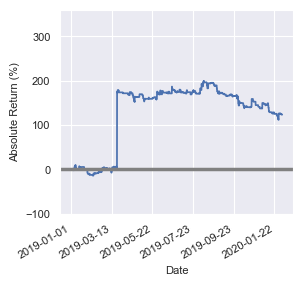

In [68]:
# Table 1/2 PM results and Figure 1a plot
params = fit_regression(rankdist=True)
show_results(testset, params=params, odds="b365", rankdist=True)
plot_results()

Dependent variable:	outcome
N:			15854
R-squared:		0.1586
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.005 0.025 39.826 0.000  0.956   1.055
wikibuzz     0.010 0.004  2.265 0.024  0.001   0.018
_cons       -0.031 0.013 -2.323 0.020 -0.057  -0.005

Bets considered (2 * Matches): 5156
Number of bets placed: 276
Mean overround (%): 6.456499124919013
Absolute amount bet: 4.987843280942048
Absolute return: 1.4372911056216515
ROI (%): 28.815883432291646


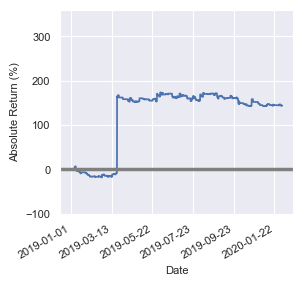

In [69]:
# Table 1/2 PM w/o RD results and Figure 1b plot
params = fit_regression(rankdist=False)
show_results(testset, params=params, odds="b365", rankdist=False)
plot_results()

Dependent variable:	outcome
N:			15854
R-squared:		0.1589
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.025 0.028 36.945 0.000  0.971   1.080
rankdist     0.055 0.031  1.787 0.074 -0.005   0.115
wikibuzz     0.009 0.004  2.117 0.034  0.001   0.017
_cons       -0.041 0.015 -2.831 0.005 -0.070  -0.013

-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149540233521076
-0.04149

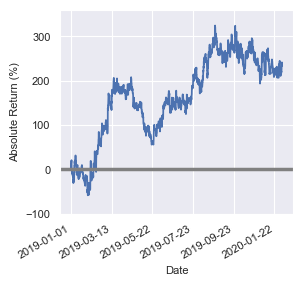

In [116]:
# Table 2 PM Best Odds results and Figure 2a plot
params = fit_regression(rankdist=True, wikibuzz=True)
show_results(testset, params=params, odds="best", rankdist=True, wikibuzz=True)
plot_results()

## 2.  Bet365 results skewed by profitable bet.

In [14]:
# Sort table by PnL size to show the Hercog bet
show_results(testset, params=params, odds="b365")
testset.sort_values(by=["PnL"], ascending=False).head()

Bets considered (2 * Matches): 5156
Number of bets placed: 312
Mean overround (%): 6.456499124919013
Absolute amount bet: 7.151004389181408
Absolute return: 1.2360930817839966
ROI (%): 17.28558695410749


,index,match_id,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,model_est_prob,kelly_betsize,PnL,Cum_PnL
1135,5883,5883,Polona Hercog,2019-03-23,2019.0,-0.001824,-1.707411,0.181818,0.540541,0.476190,1,0.497091,0.385334,1.734001,205.301298
4439,20000,20000,Veronika Kudermetova,2019-10-17,2019.0,0.226190,1.707976,0.307692,0.364964,0.307692,1,0.360454,0.076212,0.171476,284.130138
2482,12033,12033,Yulia Putintseva,2019-06-20,2019.0,0.976744,1.032863,0.266667,0.279330,0.250000,1,0.307616,0.055840,0.153559,163.502452
5104,2540,2540,Sofia Kenin,2020-01-30,2020.0,0.933333,1.061726,0.266667,0.277778,0.248139,1,0.303912,0.050789,0.139668,234.296034
3209,15953,15953,Sofia Kenin,2019-08-06,2019.0,0.965517,0.797335,0.230947,0.238663,0.217391,1,0.263184,0.041918,0.139587,198.215572


In [15]:
# Remove Hercog bet
testset.drop(index=1135, inplace=True)

## Rerunning all results...

In [ ]:
# Table 1/2 PM results and Figure 1c plot
params = fit_regression(rankdist=True)
show_results(testset, params=params, odds="b365", rankdist=True)
plot_results()

## 3. Correct kelly.
A Kelly criterion conventionally determines the bet size in respect to bankroll at the time of the bet, not the bankroll from the start of the test period.




Dependent variable:	outcome
N:			15854
R-squared:		0.1589
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.025 0.028 36.945 0.000  0.971   1.080
rankdist     0.055 0.031  1.787 0.074 -0.005   0.115
wikibuzz     0.009 0.004  2.117 0.034  0.001   0.017
_cons       -0.041 0.015 -2.831 0.005 -0.070  -0.013

Bets considered (2 * Matches): 5188
Number of bets placed: 2343
Mean overround (%): -0.22149878121402455
Absolute amount bet: 76.37338944442703
Absolute return: 2.420140470779187
ROI (%): 3.1688268497500616
---------------
*Correct Kelly*
Bets considered (2 * Matches): 5188
Number of bets placed: 2343
Mean overround (%): -0.22149878121402455
Absolute amount bet: 116.58129429349343
Absolute return: -0.2019727252863166
ROI (%): -0.1732462540498525


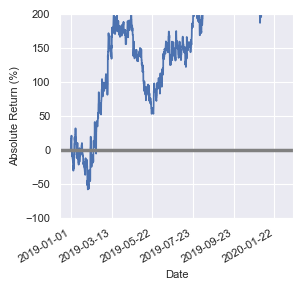

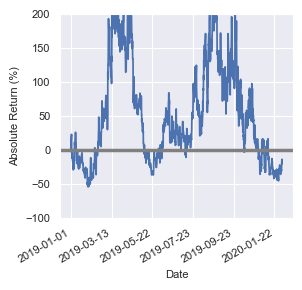

In [16]:
correct_kelly_results("best", rankdist=True)
plot_results()
correct_kelly_plot_results()

## 4. Best odds compared to simple strategy.
Below is the results from implementing no model at all and simply using the inverse average odds as the estimated probability and the best odds as the odds for returns.

In [30]:
correct_kelly_results("best", rankdist=True, wikibuzz=False)

Dependent variable:	outcome
N:			15854
R-squared:		0.1584
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.002 0.025 39.310 0.000  0.952   1.052
rankdist     0.061 0.030  2.003 0.045  0.001   0.121
_cons       -0.029 0.013 -2.172 0.030 -0.056  -0.003

Bets considered (2 * Matches): 5189
Number of bets placed: 2009
Mean overround (%): -0.22770090708685853
Absolute amount bet: 49.284454976892555
Absolute return: 1.2533214039239167
ROI (%): 2.5430359420867132
---------------
*Correct Kelly*
Bets considered (2 * Matches): 5189
Number of bets placed: 2009
Mean overround (%): -0.22770090708685853
Absolute amount bet: 40.273460742179054
Absolute return: -0.4919672371851379
ROI (%): -1.2215668286730819
